# Analyze Optical Transmission of Oatmilk

## Import modules

In [1]:
from os import path
import glob
import re
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

## Load data

In [2]:
# Define paths to data and find files matching the file name pattern
LISST_PATH = "C:/Users/kylene.cooley/Documents/prtsz_bench_test"
DATA_PATH = "oatmilk-*[0-9]percent.csv"

flist = glob.glob(DATA_PATH, root_dir=LISST_PATH, recursive=True)

In [3]:
# Define functions
def load_lisst(fpath, csvhdr):
    # Load processed LISST data
    lisst_data = pd.read_csv(fpath, names=csvhdr)
    try: lisst_data.head(1) 
    except: print("No LISST data found.")
    # Create LISST time vectors for Xarray Dataset coordinates
    lisst_time = pd.to_datetime(lisst_data[["year", "month", "day", "hour", "minute", "second"]], yearfirst=True, utc=True)
    lisst_data.insert(0, "time", lisst_time.values)
    lisst_data.set_index("time", drop=True, inplace=True)
    # print(lisst_data.head(1))
    # Convert data frames to xarray for easy manipulation
    lisst_ds = xr.Dataset.from_dataframe(lisst_data)
    return lisst_ds

In [4]:
# Load LISST CSV column names from json containing column headers
headers = pd.read_json("./inst_headers/lisst_hdr.json", typ='series', orient='records')
csvhdr = headers.iloc[0]

In [5]:
# Change first 36 column names to integer bin numbers
bins = np.arange(36)+1
csvhdr[0:36] = bins.astype(str)
# csvhdr

In [6]:
# Load data to workspace
fpath = path.join(LISST_PATH, flist[0])
lisst_ds = load_lisst(fpath, csvhdr)

## Timeseries analysis

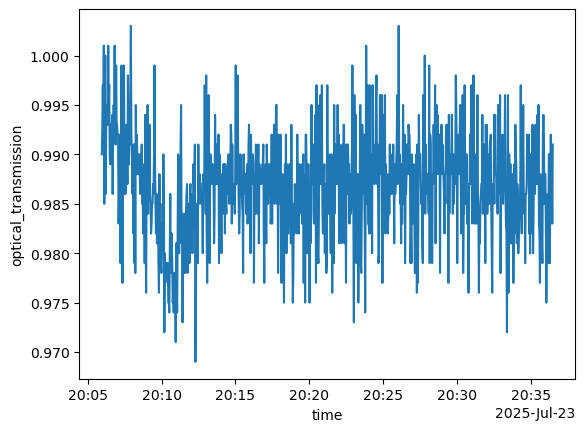

In [ ]:
lisst_ds.optical_transmission.plot()
plt.grid()
ax = plt.gca()
ax.set_ylabel()
plt.title(" ".join(["Timeseries of ", ax.get_ylabel()])+f"\n{fpath.split('\\')[-1][0:-4].replace("_", ".")}")
figname = "./figures/timeseries-"+fpath.split('\\')[-1]
plt.savefig(figname.replace("csv", "png"))

In [8]:
# Calculate average percent optical transmission
lisst_ds.optical_transmission.mean().values*100

np.float64(98.68462377317339)

## Frequency-domain analysis

Compute the Welch PSD to examine the noise floor. 

In [9]:
# Define parameters for the PSD
dt = 2
fs = 1/dt
optical_transmission = lisst_ds.optical_transmission

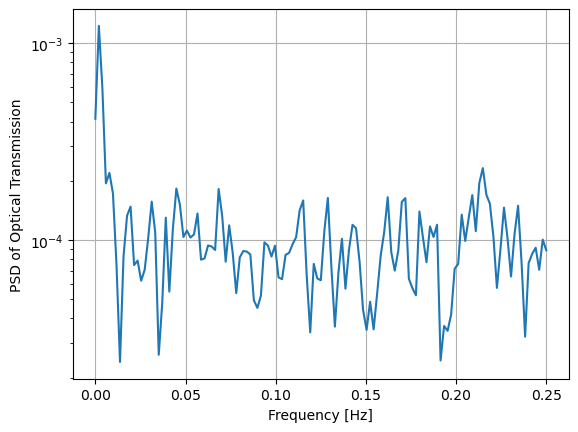

In [10]:
# Compute and plot the PSD
f, Pxx_OT = signal.welch(optical_transmission, fs)
plt.semilogy(f, Pxx_OT)
plt.xlabel("Frequency [Hz]")
plt.ylabel('PSD of Optical Transmission')
plt.grid()

# figname = "./figures/psd-"+fpath.split('\\')[-1]
# plt.savefig(figname.replace("csv", "png"))

## Particle size distribution pcolor plot

In [11]:
# make list of arrays of volume concentration by particle size bins
prt_sz = [
    lisst_ds["1"], lisst_ds["2"],
    lisst_ds["3"], lisst_ds["4"],
    lisst_ds["5"], lisst_ds["6"],
    lisst_ds["7"], lisst_ds["8"],
    lisst_ds["9"], lisst_ds["10"],
    lisst_ds["11"], lisst_ds["12"],
    lisst_ds["13"], lisst_ds["14"],
    lisst_ds["15"], lisst_ds["16"],
    lisst_ds["17"], lisst_ds["18"],
    lisst_ds["19"], lisst_ds["20"],
    lisst_ds["21"], lisst_ds["22"],
    lisst_ds["23"], lisst_ds["24"],
    lisst_ds["25"], lisst_ds["26"],
    lisst_ds["27"], lisst_ds["28"],
    lisst_ds["29"], lisst_ds["30"],
    lisst_ds["31"], lisst_ds["32"],
    lisst_ds["33"], lisst_ds["34"],
    lisst_ds["35"], lisst_ds["36"]
]

In [12]:
# Concatenate 1D arrays into 2D array
prtsz2D = xr.concat(prt_sz, pd.Index(bins, name="bin"))
prtsz2D = prtsz2D.rename("particle volume concentration")
prtsz2D = prtsz2D.assign_attrs(units="$\mu$L/L")
prtsz2D

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_90124\270873917.py:4: SyntaxWarning: invalid escape sequence '\m'
  prtsz2D = prtsz2D.assign_attrs(units="$\mu$L/L")


<xarray.DataArray 'particle volume concentration' (bin: 36, time: 917)> Size: 264kB
array([[0.0213, 0.0204, 0.019 , ..., 0.0207, 0.0204, 0.0208],
       [0.0241, 0.0235, 0.0219, ..., 0.0237, 0.023 , 0.0233],
       [0.0273, 0.0271, 0.0255, ..., 0.0273, 0.0261, 0.0263],
       ...,
       [0.    , 0.    , 0.    , ..., 0.0078, 0.0022, 0.0105],
       [0.    , 0.    , 0.    , ..., 0.0019, 0.    , 0.0036],
       [0.0027, 0.    , 0.    , ..., 0.002 , 0.    , 0.0044]],
      shape=(36, 917))
Coordinates:
  * time     (time) datetime64[ns] 7kB 2025-07-23T20:05:57 ... 2025-07-23T20:...
  * bin      (bin) int64 288B 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
Attributes:
    units:    $\mu$L/L

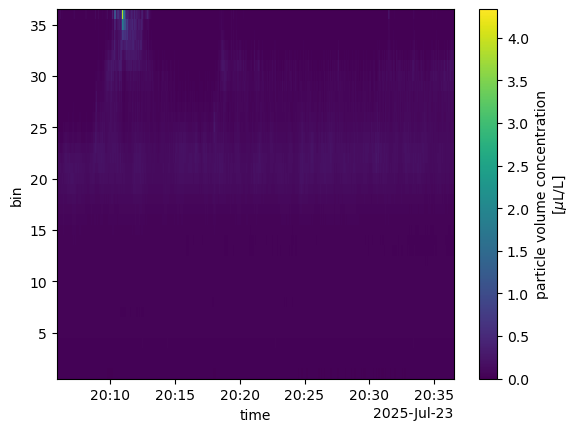

In [13]:
prtsz2D.plot.pcolormesh()


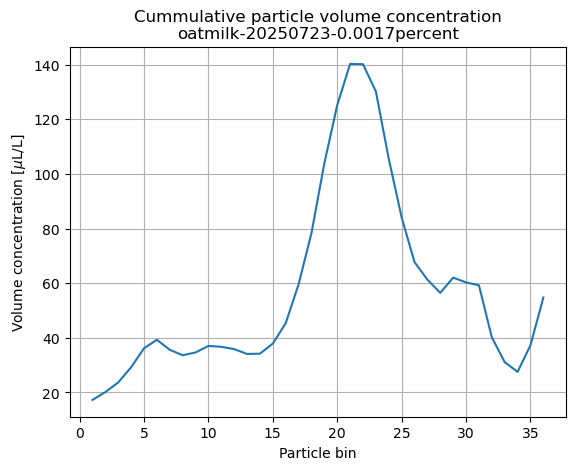

In [14]:
# Plot cummulative particle volume concentration by size bin
fig, ax = plt.subplots()
totalbins = prtsz2D.sum(dim="time")
totalbins.plot(ax=ax)
plt.title(" ".join(["Cummulative", ax.get_ylabel()])+f"\n{fpath.split('\\')[-1][0:-4].replace("_", ".")}")
ax.set_ylabel(f"Volume concentration [{prtsz2D.units}]")
ax.set_xlabel("Particle bin")
ax.grid()

figname = "./figures/particle_volume-"+fpath.split('\\')[-1]
plt.savefig(figname.replace("csv", "png"))